In [8]:
import numpy as np
from skimage import io, draw
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def _scale_region(image, region):
    polygon = np.array(region)
    polygon[:,0] = polygon[: ,0] * image.shape[0]
    polygon[:,1] = polygon[: ,1] * image.shape[1]
    return polygon

def _mask_image(image, region):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    polygon = _scale_region(image, region)
    rr, cc = draw.polygon(polygon[:, 1], polygon[:, 0], mask.shape)
    mask[rr, cc] = 255
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    return masked_image

def _compute_masked_image_stats(masked_image):
    pixels = masked_image.reshape(image.shape[0] * image.shape[1], 3)
    ix = np.nonzero(np.any(pixels, axis=1))[0]
    return pixels[ix].mean(axis=0), pixels[ix].std(axis=0)

def _compute_subtraction_value(means, stds):
    return means + 3 * stds

def subtract_background(image, region):
    masked_image = _mask_image(image, region)
    means, stds = _compute_masked_image_stats(masked_image)
    subtraction_value = _compute_subtraction_value(means, stds)
    modified_image = image - subtraction_value
    #modified_image[modified_image < 0] = 0
    return np.clip(modified_image, 0, 255).astype(np.uint8)

def save_image(name, image):
    io.imsave(name, image)


<class 'numpy.uint8'>


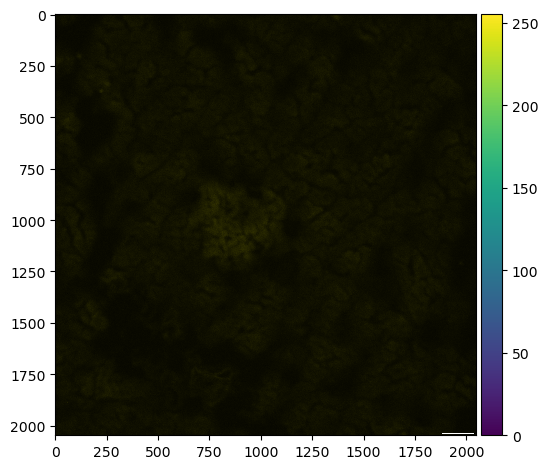

<class 'numpy.uint8'>


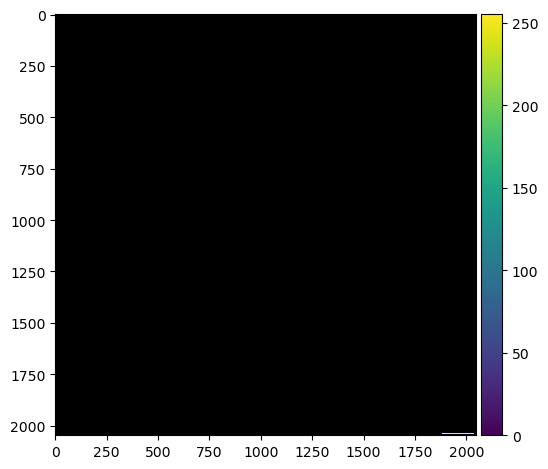

/var/folders/j7/4vqq4k6s58lbmfqjrht2h_rh0000gn/T/ipykernel_26178/599397748.py:33: UserWarning: fuck.tif is a low contrast image
  io.imsave(name, image)


In [23]:
image = io.imread('Image006_ch03_SV.tif')
region = [[0.5508796202274574, 0.3128236697806661], [0.5502132412672623, 0.3128236697806661], [0.5495468623070674, 0.3128236697806661], [0.5488804833468724, 0.3128236697806661], [0.5482141043866775, 0.3128236697806661], [0.5475477254264826, 0.3128236697806661], [0.5468813464662876, 0.3128236697806661], [0.5462149675060926, 0.3128236697806661], [0.5455485885458976, 0.3128236697806661], [0.5448822095857027, 0.3128236697806661], [0.5442158306255077, 0.3128236697806661], [0.5428894191714053, 0.3128236697806661], [0.5422230402112104, 0.3128236697806661], [0.5415566612510154, 0.3128236697806661], [0.540230249796913, 0.3128236697806661], [0.5395638708367181, 0.3128236697806661], [0.5382374593826158, 0.3128236697806661], [0.5375710804224207, 0.3128236697806661], [0.5369047014622258, 0.3128236697806661], [0.5355782900081235, 0.3128236697806661], [0.5349119110479286, 0.3128236697806661], [0.5322590881397238, 0.3134837022745735], [0.5315927091795288, 0.3134837022745735], [0.5302662977254264, 0.3134837022745735], [0.5282735073111292, 0.3141437347684809], [0.5269470958570268, 0.3148037672623883], [0.5262807168968319, 0.3148037672623883], [0.5249543054427295, 0.3148037672623883], [0.5236278939886271, 0.3154637997562957], [0.5229615150284321, 0.3154637997562957], [0.5216351035743299, 0.3161238322502031], [0.5203086921202275, 0.3161238322502031], [0.5196423131600325, 0.31678386474411047], [0.5183159017059301, 0.31678386474411047], [0.5169894902518278, 0.31744389723801786], [0.5156630787977254, 0.31810392973192525], [0.514336667343623, 0.31810392973192525], [0.5130102558895208, 0.31876396222583264], [0.5116838444354184, 0.31942399471974003], [0.510357432981316, 0.3200840272136474], [0.5077046100731113, 0.3207440597075548], [0.5063781986190089, 0.3214040922014622], [0.5050517871649066, 0.3220641246953696], [0.5023989642567018, 0.322724157189277], [0.5010725528025995, 0.3233841896831844], [0.4981531783103168, 0.3243551990251828], [0.4939073923639318, 0.3253262083671812], [0.4925809809098294, 0.32598624086108857], [0.49125456945572704, 0.32664627335499596], [0.48833519496344435, 0.3276172826969943], [0.487008783509342, 0.3282773151909017], [0.4840894090170593, 0.3282773151909017], [0.48276299756295693, 0.3289373476848091], [0.47984362307067424, 0.3299083570268075], [0.4755978371242892, 0.3308793663688058], [0.4726784626320065, 0.3318503757108042], [0.47135205117790413, 0.3325104082047116], [0.46843267668562144, 0.3325104082047116], [0.46551330219333875, 0.33348141754671], [0.4641868907392364, 0.33348141754671], [0.462860479285134, 0.3341414500406174], [0.45994110479285133, 0.3341414500406174], [0.458614693338749, 0.3348014825345248], [0.45728828188464665, 0.3354615150284322], [0.4543689073923639, 0.33643252437043053], [0.45171608448415923, 0.3370925568643379], [0.4503896730300569, 0.3377525893582453], [0.44747029853777415, 0.3377525893582453], [0.44481747562956947, 0.3390726543460601], [0.4418981011372868, 0.3390726543460601], [0.4405716896831844, 0.3397326868399675], [0.4376523151909017, 0.3407036961819659], [0.43632590373679936, 0.3407036961819659], [0.434999492282697, 0.3413637286758733], [0.4320801177904143, 0.3423347380178717], [0.43075370633631194, 0.34299477051177907], [0.42783433184402925, 0.34299477051177907], [0.4265079203899269, 0.34365480300568646], [0.4251815089358245, 0.34431483549959385], [0.4238550974817222, 0.34497486799350124], [0.42120227457351744, 0.34563490048740864], [0.4198758631194151, 0.34629493298131603], [0.41854945166531277, 0.3469549654752234], [0.41589662875710803, 0.3482750304630382], [0.4152302497969131, 0.3489350629569456], [0.41390383834281075, 0.3489350629569456], [0.4119110479285134, 0.3502551279447604], [0.41124466896831846, 0.3509151604386678], [0.40991825751421607, 0.35157519293257516], [0.4085854995938262, 0.35289525792038995], [0.4072590881397238, 0.35355529041429734], [0.40659270917952883, 0.35355529041429734], [0.4059263302193339, 0.35421532290820473], [0.4045999187652315, 0.3548753554021121], [0.40327350731112915, 0.3555353878960195], [0.4026071283509342, 0.3561954203899269], [0.40128071689683187, 0.3568554528838343], [0.40061433793663687, 0.3575154853777417], [0.3992879264825345, 0.3581755178716491], [0.3979615150284322, 0.3588355503655565], [0.3972951360682372, 0.35949558285946387], [0.3946423131600325, 0.36081564784727865], [0.3933159017059301, 0.36147568034118605], [0.39264952274573517, 0.36213571283509344], [0.39132311129163283, 0.36279574532900083], [0.39065673233143783, 0.3634557778229082], [0.3893303208773355, 0.3641158103168156], [0.38866394191714054, 0.364775842810723], [0.3860111190089358, 0.3660959077985378], [0.38534474004874086, 0.3667559402924452], [0.3846783610885459, 0.3674159727863526], [0.3826855706742486, 0.36939607026807475], [0.38201919171405363, 0.37005610276198214], [0.3813528127538586, 0.37071613525588953], [0.3800264012997563, 0.3713761677497969], [0.37936002233956134, 0.3726962327376117], [0.3786936433793664, 0.3733562652315191], [0.377367231925264, 0.3746763302193339], [0.37670085296506906, 0.3753363627132413], [0.3753744415109667, 0.37665642770105606], [0.3747080625507717, 0.37731646019496345], [0.3733816510966694, 0.37863652518277824], [0.37205523964256704, 0.37929655767668563], [0.37138886068237204, 0.3806166226645004], [0.3700624492282697, 0.3819366876523152], [0.36873603777416736, 0.3825967201462226], [0.36806965881397236, 0.3839167851340374], [0.36515028432168967, 0.3858588038180341], [0.3644839053614947, 0.3871788688058489], [0.36156453086921203, 0.38912088748984563], [0.3608981519090171, 0.389780919983753], [0.35890536149471974, 0.3924210499593826], [0.3575789500406174, 0.3937411149471974], [0.356252538586515, 0.39506117993501216], [0.3542597481722177, 0.39704127741673434], [0.3535933692120227, 0.3983613424045491], [0.3522669577579204, 0.3996814073923639], [0.35094054630381805, 0.4003414398862713], [0.35027416734362304, 0.4016615048740861], [0.3489477558895207, 0.40298156986190087], [0.34828137692932576, 0.40364160235580826], [0.3476149979691308, 0.40496166734362304], [0.3462885865150284, 0.40628173233143783], [0.34562220755483347, 0.4069417648253452], [0.3449558285946385, 0.40826182981316006], [0.3442894496344435, 0.40892186230706745], [0.3429630381803412, 0.41024192729488224], [0.34229665922014624, 0.41090195978878963], [0.34163028025995124, 0.411561992282697], [0.3409639012997563, 0.4128820572705118], [0.34029752233956134, 0.4135420897644192], [0.3396311433793664, 0.4142021222583266], [0.3396311433793664, 0.414862154752234], [0.3389647644191714, 0.4155221872461414], [0.3376320064987815, 0.41750228472786355], [0.3376320064987815, 0.41816231722177094], [0.3369656275385865, 0.41882234971567833], [0.33629924857839155, 0.4201424147034931], [0.33629924857839155, 0.4208024471974005], [0.3356328696181966, 0.4208024471974005], [0.3356328696181966, 0.4221225121852153], [0.3349664906580016, 0.4227825446791227], [0.33430011169780666, 0.4234425771730301], [0.33430011169780666, 0.42410260966693747], [0.3336337327376117, 0.42476264216084486], [0.3329673537774167, 0.42542267465475225], [0.33230097481722176, 0.42740277213647443], [0.3316345958570268, 0.4280628046303818], [0.3316345958570268, 0.4287228371242892], [0.33096821689683187, 0.4293828696181966], [0.33096821689683187, 0.4307029346060114], [0.33030183793663687, 0.4313629670999188], [0.33030183793663687, 0.43268303208773357], [0.3296354589764419, 0.43334306458164096], [0.328969080016247, 0.43466312956945574], [0.328969080016247, 0.43532316206336313], [0.32830270105605197, 0.4366432270511779], [0.327636322095857, 0.4392833570268075], [0.327636322095857, 0.44060342201462227], [0.3269699431356621, 0.44192348700243705], [0.3259925873273761, 0.446156580016247], [0.3253262083671812, 0.44747664500406176], [0.3253262083671812, 0.4503896730300569], [0.3246598294069862, 0.4517097380178717], [0.3236824735987002, 0.45462276604386676], [0.3230160946385053, 0.45594283103168154], [0.3230160946385053, 0.4588558590576767], [0.32203873883021933, 0.4617688870836718], [0.3213723598700244, 0.4630889520714866], [0.3213723598700244, 0.4660019800974817], [0.3207059809098294, 0.4673220450852965], [0.32003960194963443, 0.4686421100731113], [0.32003960194963443, 0.4699621750609261], [0.3193732229894395, 0.47128224004874086], [0.3193732229894395, 0.47260230503655565], [0.31870684402924454, 0.47392237002437043], [0.31804046506904954, 0.4759024675060926], [0.31804046506904954, 0.4772225324939074], [0.31804046506904954, 0.4778825649878148], [0.3173740861088546, 0.47986266246953696], [0.3173740861088546, 0.48118272745735174], [0.3173740861088546, 0.48184275995125914], [0.31670770714865965, 0.4838228574329813], [0.31670770714865965, 0.4844828899268887], [0.31670770714865965, 0.4858029549147035], [0.31604132818846464, 0.4871230199025183], [0.31604132818846464, 0.48778305239642566], [0.31604132818846464, 0.48844308489033306], [0.31604132818846464, 0.48976314987814784], [0.31604132818846464, 0.49042318237205523], [0.31604132818846464, 0.49174324735987], [0.31604132818846464, 0.4930633123476848], [0.31604132818846464, 0.4943833773354996], [0.31604132818846464, 0.49570344232331437], [0.31604132818846464, 0.4992765028432169], [0.31604132818846464, 0.5005965678310317], [0.31604132818846464, 0.5019166328188465], [0.31604132818846464, 0.5032366978066612], [0.31604132818846464, 0.5061497258326564], [0.31604132818846464, 0.5090627538586515], [0.31670136068237204, 0.5103828188464663], [0.31670136068237204, 0.5117028838342811], [0.31670136068237204, 0.5146159118602762], [0.3173613931762794, 0.515935976848091], [0.3173613931762794, 0.5188490048740861], [0.3173613931762794, 0.5217620329000813], [0.3173613931762794, 0.5230820978878961], [0.3183324025182778, 0.5259951259138912], [0.3183324025182778, 0.527315190901706], [0.3183324025182778, 0.5302282189277011], [0.3183324025182778, 0.5315482839155159], [0.3183324025182778, 0.5344613119415109], [0.3193034118602762, 0.537374339967506], [0.3193034118602762, 0.5386944049553208], [0.3193034118602762, 0.5400144699431356], [0.3193034118602762, 0.5429274979691308], [0.3199634443541836, 0.5442475629569455], [0.3199634443541836, 0.5471605909829407], [0.3199634443541836, 0.5484806559707555], [0.320623476848091, 0.5498007209585702], [0.320623476848091, 0.5527137489845654], [0.3212835093419984, 0.5540338139723802], [0.32225451868399674, 0.5582669069861901], [0.32291455117790413, 0.5595869719740049], [0.3238855605199025, 0.5625], [0.3245455930138099, 0.5651401299756296], [0.32551660235580826, 0.5680531580016247], [0.32617663484971565, 0.5693732229894395], [0.32846770917952883, 0.5736063160032494], [0.3291277416734362, 0.5749263809910642], [0.3300987510154346, 0.5778394090170593], [0.330758783509342, 0.5791594740048741], [0.3314188160032494, 0.5804795389926889], [0.33238982534524775, 0.583392567018684], [0.33370989033306253, 0.5840525995125914], [0.3343699228269699, 0.5853726645004061], [0.3363119415109667, 0.5882856925264013], [0.3376320064987815, 0.5896057575142161], [0.3389520714865963, 0.5909258225020309], [0.3396121039805037, 0.5922458874898456], [0.3428741876523152, 0.5964789805036556], [0.34419425264013, 0.5977990454914703], [0.3448542851340374, 0.5991191104792851], [0.34749441510966694, 0.6017592404549147], [0.3488144800974817, 0.6030793054427295], [0.35075649878147847, 0.6059923334687246], [0.35339662875710803, 0.6086324634443542], [0.3547166937449228, 0.609952528432169], [0.35762972177091795, 0.6118945471161658], [0.3602698517465475, 0.6145346770917953], [0.3615899167343623, 0.6158547420796101], [0.36450294476035744, 0.6177967607636068], [0.3658230097481722, 0.6191168257514216], [0.367143074735987, 0.6204368907392364], [0.37005610276198214, 0.6223789094232332], [0.3713761677497969, 0.6236989744110479], [0.37428919577579206, 0.6246699837530463], [0.37560926076360684, 0.6259900487408611], [0.3785222887896019, 0.6269610580828595], [0.3798423537774167, 0.6282811230706743], [0.38275538180341184, 0.6292521324126726], [0.3840754467912266, 0.6305721974004874], [0.38698847481722176, 0.6315432067424858], [0.38830853980503655, 0.6322032392363932], [0.3912215678310317, 0.6331742485783916], [0.39704762388302195, 0.6351162672623883], [0.3999606519090171, 0.6360872766043867], [0.40287367993501216, 0.637058285946385], [0.4103561636880585, 0.6392541632818847], [0.41326919171405363, 0.640225172623883], [0.4145892567018684, 0.6408852051177905], [0.4207516754670999, 0.6424210499593827], [0.42366470349309504, 0.643392059301381], [0.4265777315190902, 0.6443630686433793], [0.4294907595450853, 0.6453340779853778], [0.4356531783103168, 0.64686992282697], [0.43856620633631194, 0.64686992282697], [0.4447286251015435, 0.6484057676685622], [0.44764165312753856, 0.6493767770105605], [0.4505546811535337, 0.6493767770105605], [0.45346770917952883, 0.6503477863525589], [0.45638073720552397, 0.6503477863525589], [0.4592937652315191, 0.6503477863525589], [0.46220679325751424, 0.6503477863525589], [0.4651198212835093, 0.6503477863525589], [0.46803284930950445, 0.6503477863525589], [0.4709458773354996, 0.6503477863525589], [0.4738589053614947, 0.6503477863525589], [0.47809199837530464, 0.6503477863525589], [0.4794120633631194, 0.6503477863525589], [0.4807321283509342, 0.6503477863525589], [0.4849652213647441, 0.6496814073923639], [0.4862852863525589, 0.649015028432169], [0.4876053513403737, 0.648348649471974], [0.49024548131600326, 0.6476822705117791], [0.49156554630381805, 0.6463558590576767], [0.49288561129163283, 0.6463558590576767], [0.4942056762794476, 0.6450294476035743], [0.4955257412672624, 0.6443630686433793], [0.4968458062550772, 0.6436966896831844], [0.49816587124289197, 0.6430303107229894], [0.49948593623070675, 0.6423639317627945], [0.5008060012185215, 0.6410375203086921], [0.5014660337124289, 0.6403711413484972], [0.5043790617384241, 0.6384227761982129], [0.5056991267262388, 0.6377563972380179], [0.5083392567018684, 0.6357636068237206], [0.5096593216896832, 0.6344371953696182], [0.510979386677498, 0.6337708164094232], [0.5122994516653128, 0.6324444049553208], [0.5152124796913079, 0.6304960398050365], [0.5165325446791227, 0.6298296608448416], [0.5194455727051178, 0.6278812956945573], [0.5236786657189277, 0.625577528432169], [0.5265916937449229, 0.6236291632818847], [0.5279117587327377, 0.6223027518277823], [0.5321448517465476, 0.619688007717303], [0.5350578797725426, 0.6187106519090171], [0.5379709077985377, 0.6167622867587328], [0.5408839358245329, 0.6148139216084484], [0.543796963850528, 0.6128655564581641], [0.5451170288383428, 0.6115391450040617], [0.5480300568643379, 0.6105617891957758], [0.5493501218521527, 0.6092353777416735], [0.5522631498781478, 0.6072870125913891], [0.5535832148659626, 0.6059606011372868], [0.5564962428919578, 0.6040122359870025], [0.5578163078797725, 0.6026858245329001], [0.5607293359057677, 0.6007374593826158], [0.5620494008935825, 0.5994110479285134], [0.5639914195775793, 0.5964916734362307], [0.565311484565394, 0.5951652619821284], [0.5679516145410236, 0.5925124390739236], [0.5692716795288384, 0.5911860276198213], [0.5699317120227457, 0.5898596161657189], [0.5731937956945573, 0.5856138302193339], [0.5741648050365556, 0.5826944557270511], [0.5761068237205524, 0.5797750812347685], [0.5774268887083672, 0.5784486697806661], [0.5793689073923639, 0.5755292952883835], [0.5800289398862714, 0.5742028838342811], [0.5831069760357434, 0.568034118602762], [0.587727203493095, 0.5634075446791227], [0.5896692221770918, 0.5604881701868399], [0.5927472583265637, 0.5543194049553208], [0.5958252944760357, 0.5481506397238017], [0.5977673131600325, 0.5452312652315191], [0.6023875406173842, 0.5406046913078798], [0.604329559301381, 0.5376853168155971], [0.607407595450853, 0.531516551584078], [0.6087276604386678, 0.5301901401299757], [0.6126116978066612, 0.5243513911454102], [0.614553716490658, 0.5214320166531276], [0.6155247258326564, 0.5185126421608448], [0.6168447908204712, 0.5171862307067425], [0.618164855808286, 0.5158598192526401], [0.6191358651502843, 0.5129404447603574], [0.6197958976441917, 0.5116140333062551], [0.6217759951259139, 0.5089612103980503], [0.6217759951259139, 0.507634798943948], [0.6227470044679123, 0.5047154244516653], [0.624378046303818, 0.5004696385052803], [0.6250380787977254, 0.4991432270511779], [0.6250380787977254, 0.4978168155970755], [0.6256981112916328, 0.4964904041429732], [0.6266691206336312, 0.4935710296506905], [0.6266691206336312, 0.49224461819658816], [0.6276401299756296, 0.48932524370430547], [0.6276401299756296, 0.4864058692120227], [0.6286111393176279, 0.48348649471974003], [0.6286111393176279, 0.47731772948822093], [0.6295821486596264, 0.47439835499593824], [0.6295821486596264, 0.47147898050365555], [0.6311179935012186, 0.46531021527213645], [0.6311179935012186, 0.46239084077985376], [0.6326538383428107, 0.45622207554833466], [0.6326538383428107, 0.45330270105605197], [0.6326538383428107, 0.4503833265637693], [0.6336248476848091, 0.4474639520714866], [0.6336248476848091, 0.4445445775792039], [0.6336248476848091, 0.4416252030869212], [0.6345958570268074, 0.43578645410235584], [0.6345958570268074, 0.43446004264825344], [0.6345958570268074, 0.43154066815597075], [0.6345958570268074, 0.428887845247766], [0.6345958570268074, 0.42596847075548333], [0.6345958570268074, 0.424642059301381], [0.6345958570268074, 0.42331564784727865], [0.6345958570268074, 0.42198923639317626], [0.6345958570268074, 0.4206628249390739], [0.6345958570268074, 0.41774345044679123], [0.6345958570268074, 0.4164170389926889], [0.6345958570268074, 0.4150906275385865], [0.6345958570268074, 0.41376421608448416], [0.6345958570268074, 0.4124378046303818], [0.6345958570268074, 0.4111113931762794], [0.6345958570268074, 0.4097849817221771], [0.6345958570268074, 0.40845857026807475], [0.6339294780666125, 0.40713215881397236], [0.6339294780666125, 0.40580574735987], [0.6339294780666125, 0.40315292445166534], [0.6339294780666125, 0.40182651299756295], [0.6339294780666125, 0.4005001015434606], [0.6332630991064175, 0.3978472786352559], [0.6332630991064175, 0.3971808996750609], [0.6332630991064175, 0.3958544882209586], [0.6332630991064175, 0.39386169780666125], [0.6332630991064175, 0.3931953188464663], [0.6332630991064175, 0.3918689073923639], [0.6325967201462226, 0.39120252843216896], [0.6325967201462226, 0.3898761169780666], [0.6325967201462226, 0.3892097380178717], [0.6325967201462226, 0.3878833265637693], [0.6325967201462226, 0.38721694760357434], [0.6319303411860276, 0.385890536149472], [0.6319303411860276, 0.385224157189277], [0.6319303411860276, 0.38389774573517466], [0.6312639622258327, 0.3832313667749797], [0.6312639622258327, 0.38123857636068237], [0.6305975832656376, 0.37991216490658003], [0.6299312043054427, 0.37858575345247764], [0.6299312043054427, 0.3772593419983753], [0.6292648253452477, 0.37593293054427296], [0.6285984463850528, 0.3746065190901706], [0.6285984463850528, 0.3732801076360682], [0.6272656884646629, 0.37128731722177094], [0.626599309504468, 0.36996090576766855], [0.6259329305442729, 0.3686344943135662], [0.624600172623883, 0.3659816714053615], [0.6239337936636881, 0.36531529244516653], [0.6232674147034931, 0.3639888809910642], [0.6226010357432982, 0.3633225020308692], [0.6219346567831032, 0.36199609057676685], [0.6212682778229082, 0.3613297116165719], [0.6212682778229082, 0.36000330016246956], [0.6206018988627132, 0.35933692120227456], [0.6192754874086109, 0.3586705422420796], [0.6192754874086109, 0.35800416328188467], [0.6186091084484159, 0.3566777518277823], [0.6179427294882209, 0.35601137286758733], [0.6179427294882209, 0.3553449939073924], [0.617276350528026, 0.3546786149471974], [0.616609971567831, 0.3546786149471974], [0.6159435926076361, 0.35401223598700243], [0.6152772136474411, 0.3526794780666125], [0.6146108346872461, 0.35201309910641754], [0.6132780767668562, 0.35068034118602764], [0.6126116978066612, 0.35001396222583264], [0.6119453188464663, 0.3493475832656377], [0.6119453188464663, 0.34868120430544275], [0.6112789398862714, 0.34868120430544275], [0.6106125609260764, 0.3473484463850528], [0.6099461819658814, 0.34668206742485785], [0.6092798030056864, 0.34668206742485785], [0.6092798030056864, 0.34601568846466285], [0.6086134240454915, 0.3453493095044679], [0.6079470450852965, 0.3453493095044679], [0.6079470450852965, 0.34468293054427296], [0.6072806661251016, 0.34468293054427296], [0.6066142871649066, 0.344016551584078], [0.6066142871649066, 0.343350172623883], [0.6059479082047117, 0.343350172623883], [0.6052815292445166, 0.34268379366368806], [0.6046151502843217, 0.34268379366368806], [0.6039487713241267, 0.3420174147034931], [0.6032823923639318, 0.3413510357432981], [0.6026160134037368, 0.3413510357432981], [0.6026160134037368, 0.34068465678310317], [0.6012832554833468, 0.3400182778229082], [0.6006168765231519, 0.3393518988627132], [0.5999504975629569, 0.3386855199025183], [0.599284118602762, 0.3386855199025183], [0.598617739642567, 0.3380191409423233], [0.5979513606823721, 0.3373527619821283], [0.5972849817221771, 0.3373527619821283], [0.5966186027619821, 0.3366863830219334], [0.5959522238017871, 0.3366863830219334], [0.5952858448415922, 0.33602000406173843], [0.5946194658813972, 0.3353536251015435], [0.5939530869212023, 0.3353536251015435], [0.5932867079610074, 0.3346872461413485], [0.5926203290008123, 0.3346872461413485], [0.5919539500406173, 0.33402086718115354], [0.5912875710804224, 0.33402086718115354], [0.5906211921202275, 0.3333544882209586], [0.5899548131600325, 0.3326881092607636], [0.5892884341998376, 0.3326881092607636], [0.5879556762794476, 0.33202173030056864], [0.5872892973192526, 0.3313553513403737], [0.5866229183590577, 0.3313553513403737], [0.5852901604386678, 0.3306889723801787], [0.5846237814784728, 0.33002259341998375], [0.5839574025182778, 0.33002259341998375], [0.5839574025182778, 0.3293562144597888], [0.5832910235580828, 0.3293562144597888], [0.5826246445978879, 0.3293562144597888], [0.5819582656376929, 0.32868983549959385], [0.581291886677498, 0.32868983549959385], [0.580625507717303, 0.32868983549959385], [0.580625507717303, 0.32802345653939885], [0.5799591287571081, 0.32802345653939885], [0.579292749796913, 0.32802345653939885], [0.5786263708367181, 0.3273570775792039], [0.5779599918765231, 0.3273570775792039], [0.5772936129163282, 0.3273570775792039], [0.5766272339561332, 0.3273570775792039], [0.5759608549959383, 0.3273570775792039], [0.5759608549959383, 0.32669069861900896], [0.5752944760357434, 0.32669069861900896], [0.5746280970755483, 0.32669069861900896], [0.5739617181153533, 0.32602431965881395], [0.5732953391551584, 0.32602431965881395], [0.5726289601949635, 0.32602431965881395], [0.5719625812347685, 0.32602431965881395], [0.5712962022745736, 0.32602431965881395], [0.5706298233143785, 0.325357940698619], [0.5699634443541836, 0.325357940698619], [0.5692970653939886, 0.325357940698619], [0.5679643074735987, 0.32469156173842406], [0.5672979285134038, 0.32469156173842406], [0.5666315495532088, 0.32402518277822906], [0.5646387591389115, 0.32402518277822906], [0.5639723801787165, 0.32402518277822906], [0.5626396222583265, 0.3233588038180341], [0.5619732432981316, 0.3233588038180341], [0.5613068643379366, 0.3233588038180341], [0.5606404853777417, 0.3233588038180341], [0.5599741064175467, 0.3233588038180341], [0.5593077274573518, 0.3233588038180341], [0.5586413484971567, 0.3233588038180341], [0.5579749695369618, 0.3233588038180341], [0.5573085905767668, 0.3233588038180341], [0.5566422116165719, 0.3233588038180341], [0.5566422116165719, 0.32269242485783917], [0.555975832656377, 0.32269242485783917], [0.555309453696182, 0.32269242485783917], [0.554643074735987, 0.32269242485783917], [0.553976695775792, 0.32269242485783917], [0.5533103168155971, 0.32269242485783917], [0.5526439378554021, 0.32269242485783917], [0.5519775588952072, 0.32269242485783917], [0.5513111799350122, 0.32269242485783917], [0.5506448009748173, 0.32269242485783917], [0.5499784220146222, 0.32269242485783917], [0.5493120430544273, 0.32202604589764416], [0.5479792851340374, 0.32202604589764416], [0.5473129061738424, 0.32202604589764416], [0.5466465272136475, 0.32202604589764416], [0.5459801482534524, 0.32202604589764416], [0.5453137692932575, 0.32202604589764416], [0.5446473903330625, 0.32202604589764416], [0.5439810113728676, 0.32202604589764416], [0.5433146324126726, 0.32202604589764416], [0.5426482534524777, 0.32202604589764416], [0.5419818744922827, 0.3213596669374492], [0.5413154955320877, 0.3213596669374492], [0.5406491165718927, 0.3213596669374492], [0.5399827376116978, 0.3213596669374492], [0.5393163586515028, 0.32069328797725427], [0.5386499796913079, 0.32069328797725427], [0.537983600731113, 0.32069328797725427], [0.537317221770918, 0.32069328797725427], [0.536650842810723, 0.32069328797725427], [0.535984463850528, 0.32069328797725427], [0.5353180848903331, 0.32069328797725427], [0.5346517059301381, 0.32069328797725427], [0.5339853269699432, 0.32069328797725427], [0.5333189480097482, 0.3200269090170593], [0.5326525690495532, 0.3200269090170593], [0.5319861900893582, 0.3200269090170593], [0.5313198111291633, 0.3200269090170593], [0.5306534321689683, 0.3200269090170593], [0.5299870532087734, 0.3193605300568643], [0.5293206742485784, 0.3193605300568643], [0.5286542952883835, 0.3193605300568643], [0.5279879163281884, 0.3193605300568643], [0.5279879163281884, 0.3186941510966694], [0.5273215373679935, 0.3186941510966694], [0.5266551584077985, 0.3186941510966694], [0.5259887794476036, 0.3186941510966694], [0.5253224004874086, 0.31802777213647443], [0.5246560215272137, 0.31802777213647443], [0.5239896425670186, 0.31802777213647443], [0.5233232636068237, 0.31802777213647443], [0.5233232636068237, 0.3173613931762794], [0.5219905056864338, 0.3173613931762794], [0.5213241267262388, 0.3173613931762794], [0.5206577477660439, 0.3166950142160845], [0.519991368805849, 0.3166950142160845], [0.5186649573517466, 0.3166950142160845], [0.5179985783915516, 0.31602863525588953], [0.5166658204711616, 0.31602863525588953], [0.5159994415109667, 0.31536225629569453], [0.5153330625507717, 0.31536225629569453], [0.5140066510966693, 0.31536225629569453], [0.5133402721364744, 0.3146958773354996], [0.5126738931762794, 0.31402949837530464], [0.5113474817221771, 0.31402949837530464], [0.5106811027619821, 0.31402949837530464], [0.5100147238017871, 0.3133631194151097], [0.5093483448415922, 0.3133631194151097], [0.5080219333874898, 0.3126967404549147], [0.5073555544272949, 0.3126967404549147], [0.5066891754670999, 0.31203036149471974], [0.5053627640129975, 0.31203036149471974], [0.5046963850528026, 0.3113639825345248], [0.5040300060926076, 0.3113639825345248], [0.5020372156783103, 0.3106976035743298], [0.5013708367181153, 0.3106976035743298], [0.5007044577579204, 0.31003122461413485], [0.49937169983753044, 0.3093648456539399], [0.4987053208773355, 0.3093648456539399], [0.49803894191714054, 0.3093648456539399], [0.4967061839967506, 0.3086984666937449], [0.49603980503655565, 0.30803208773354995], [0.4953734260763607, 0.30803208773354995], [0.4947070471161657, 0.30803208773354995], [0.49404066815597075, 0.307365708773355], [0.4933742891957758, 0.307365708773355], [0.4927079102355808, 0.30669932981316006], [0.49204153127538586, 0.30669932981316006], [0.4913751523151909, 0.30669932981316006], [0.49004874086108857, 0.30603295085296506], [0.48938236190089357, 0.3053665718927701], [0.4887159829406986, 0.3053665718927701], [0.4880496039805037, 0.3053665718927701], [0.4873832250203087, 0.30470019293257516], [0.48671684606011373, 0.30403381397238016], [0.4860504670999188, 0.30403381397238016], [0.48471770917952883, 0.3033674350121852], [0.4840513302193339, 0.30270105605199027], [0.4833849512591389, 0.30270105605199027], [0.482052193338749, 0.30203467709179527], [0.48138581437855404, 0.30203467709179527], [0.48071943541835904, 0.3013682981316003], [0.4800530564581641, 0.3013682981316003], [0.47938667749796915, 0.3007019191714054], [0.47872029853777415, 0.3007019191714054], [0.4780539195775792, 0.30003554021121037], [0.47738754061738425, 0.30003554021121037], [0.47672116165718925, 0.2993691612510154], [0.4760547826969943, 0.2987027822908205], [0.47538840373679936, 0.2987027822908205], [0.4747220247766044, 0.29803640333062553], [0.4740556458164094, 0.29803640333062553], [0.4740556458164094, 0.29737002437043053], [0.47338926685621446, 0.29737002437043053], [0.47338926685621446, 0.2967036454102356], [0.4727228878960195, 0.2967036454102356]]


print(type(image[0][0][0]))
io.imshow(image)
io.show()
new_image = subtract_background(image, region)
"""
for i in new_image:
    for j in i:
        if j[0] > 0:
            print(j)
"""
print(type(new_image[0][0][0]))
io.imshow(new_image)
io.show()
save_image('fuck.tif', new_image)